In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft
import matplotlib.gridspec as gridspec

client = tt.startdask(nthreads=1,n_workers = 52)

client

<Client: 'tcp://127.0.0.1:43765' processes=52 threads=52, memory=416.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 52
Total threads: 52,Total memory: 416.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43765,Workers: 52
Dashboard: /proxy/8787/status,Total threads: 52
Started: Just now,Total memory: 416.00 GiB
Comm: tcp://127.0.0.1:42689,Total threads: 1
Dashboard: /proxy/46223/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:38511,


# Show Realistic - NoRidge anomaly for modes 2+ at each resolution, followed by stacked bar plot below


In [2]:

data = {}
for expt in ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40"]:
# for expt in ["full-40","beamless-40","smooth-40"]:
    path = Path(f"/scratch/nm03/ab8992/april-manytimes") / expt
    bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").sel(yb = slice(-120,120))
    times = os.listdir(path)
    if "40" in expt:
        t0 = "t0-4216"
    else:
        t0 = "t0-22000"
    data[expt] = xr.merge(
    [
        xr.open_dataset(path / t0 / "EF_alongbeam.nc",decode_times= False).rename({"EF":"EF_alongbeam"}).mean("time").load(),
        xr.open_dataset(path / t0 / "EF_acrossbeam.nc",decode_times= False).rename({"EF":"EF_acrossbeam"}).mean("time").load(),
        xr.open_dataset(path / t0 / "EF_alongbeam_forward.nc",decode_times= False),
        xr.open_dataset(path / t0 / "EF_alongbeam_backward.nc",decode_times= False),
        xr.open_dataset(path / t0 / "EF_alongbeam_xterm.nc",decode_times= False),
        xr.open_dataset(path / t0 / "KE_forward.nc",decode_times= False,decode_cf = False),
        xr.open_dataset(path / t0 / "KE_backward.nc",decode_times= False,decode_cf = False),
        xr.open_dataset(path / t0 / "KE_cross.nc",decode_times= False,decode_cf = False),
        bathy.rename({"depth":"bathy"}) * -1
     ]
).expand_dims({"time":[t0.split("t0-")[1]]})
    for i in range(len(times)):
        if times[i] == t0:
            continue
        try:
            data[expt] = xr.concat(
            [
                data[expt],
                xr.merge(
                    [
                        xr.open_dataset(path / times[i] / "EF_alongbeam.nc",decode_times= False,decode_cf = False).rename({"EF":"EF_alongbeam"}).mean("time").load(),
                        xr.open_dataset(path / times[i] / "EF_acrossbeam.nc",decode_times= False,decode_cf = False).rename({"EF":"EF_acrossbeam"}).mean("time").load(),
                        xr.open_dataset(path / times[i] / "EF_alongbeam_forward.nc",decode_times= False,decode_cf = False),
                        xr.open_dataset(path / times[i] / "EF_alongbeam_backward.nc",decode_times= False,decode_cf = False),
                        xr.open_dataset(path / times[i] / "EF_alongbeam_xterm.nc",decode_times= False,decode_cf = False),
                        xr.open_dataset(path / times[i] / "KE_forward.nc",decode_times= False,decode_cf = False),
                        xr.open_dataset(path / times[i] / "KE_backward.nc",decode_times= False,decode_cf = False),
                        xr.open_dataset(path / times[i] / "KE_cross.nc",decode_times= False,decode_cf = False),
                        # xr.open_dataset(path / times[i] / "EF_acrossbeam_forward.nc",decode_times= False),
                        # xr.open_dataset(path / times[i] / "EF_acrossbeam_backward.nc",decode_times= False),
                        # xr.open_dataset(path / times[i] / "EF_acrossbeam_xterm.nc",decode_times= False),
                        bathy.rename({"depth":"bathy"}) * -1
                    ]
                ).expand_dims({"time":[times[i].split("t0-")[1]]}),
            ],
            dim = "time"
            )
        except Exception as e:
            print(f"Error processing time {times[i]} for experiment {expt}: {e}")

    data[expt] = data[expt].mean("time")


Error processing time t0-7560 for experiment full-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/full-40/t0-7560/EF_alongbeam.nc'
Error processing time t0-4680 for experiment full-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/full-40/t0-4680/EF_alongbeam.nc'
Error processing time t0-5400 for experiment full-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/full-40/t0-5400/EF_alongbeam.nc'
Error processing time t0-6120 for experiment full-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/full-40/t0-6120/EF_alongbeam.nc'
Error processing time t0-8280 for experiment full-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/full-40/t0-8280/EF_alongbeam.nc'
Error processing time t0-9720 for experiment full-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/full-40/t0-9720/EF_alongbeam.nc'
Error processing time t0-900

[Text(4, 0, 'Rise'), Text(8, 0, 'Middle'), Text(12, 0, 'Start')]

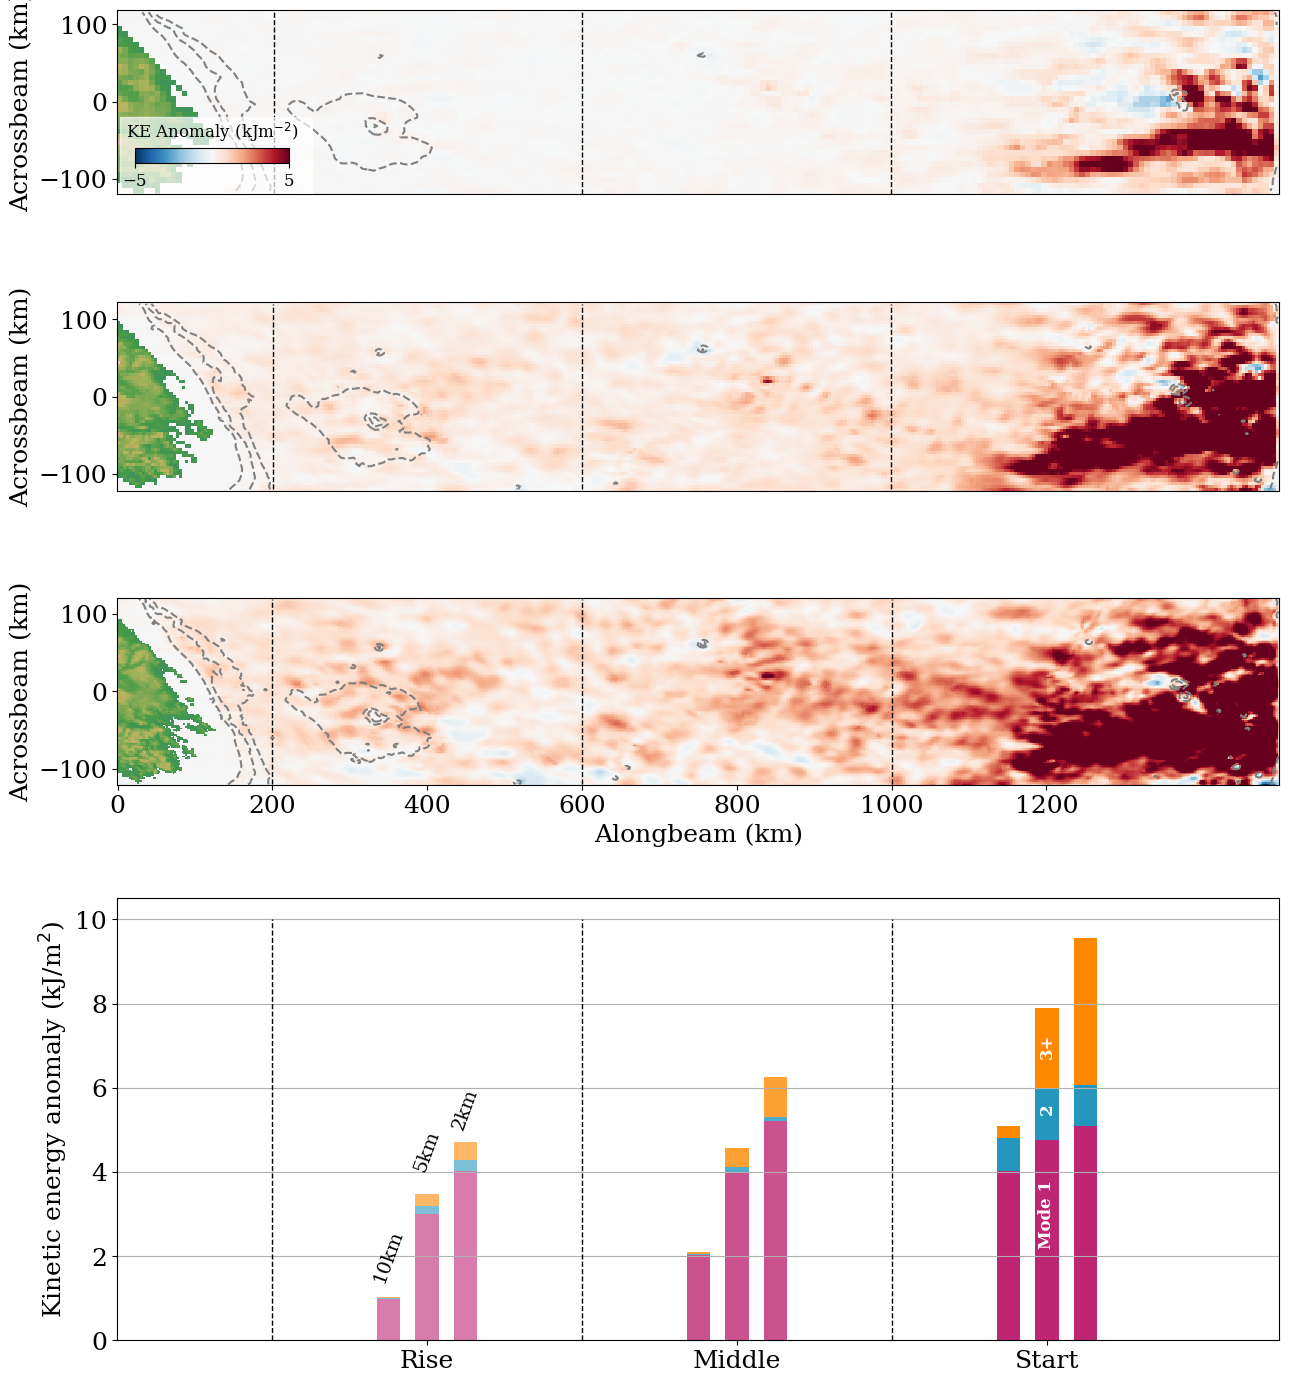

In [24]:
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)


def mean_KE_in_box(data,xlim = [None,None],ylim = [None,None],mask = None):
    if mask == None:
        out = data.sel(xb = slice(xlim[0],xlim[1]), yb = slice(ylim[0],ylim[1])).mean(["xb","yb"])
    else:
        out = mask(data).mean("xb","yb")
    return out



def data_lookup(mode,xlim = [None,None],ylim = [None,None],res = [10,20,40],sum_below = False,sum_above = False,mask = None):
    """
    Returns summed numpy array with n values. n for number of expts """
    # res = 10,20,40 # temporary until we load more data
    if sum_below:
        mode = slice(0,mode + 1)
    elif sum_above:
        mode = slice(mode,None)
    else:
        mode = [mode]
    out = []
    for i in res:
        KE = data[f"full-{i}"][f"KE_forward"] + data[f"full-{i}"][f"KE_backward"] + data[f"full-{i}"][f"KE_cross"]
        KE -= (data[f"beamless-{i}"][f"KE_forward"] + data[f"beamless-{i}"][f"KE_backward"] + data[f"beamless-{i}"][f"KE_cross"])
        out.append(
            KE.isel(mode = mode).sum("mode").sel(xb = slice(xlim[0],xlim[1]), yb = slice(ylim[0],ylim[1])).mean(["xb","yb"])
        )
    return np.array(out)

sp = np.array([4,8,12]) ## These are in coordinates from 0 to 12

def plot_EF_bars(ax,ylim = [None,None],mask = None):


    width = 0.5

    # sp *= normalise
    bar_positions = np.array([
        sp[0] - width, sp[0], sp[0] + width,  # First group
        sp[1] - width, sp[1], sp[1] + width,  # First group
        sp[2] - width, sp[2], sp[2] + width,  # First group
    ])

    colours = ['grey','#be2573','#2596be','#ff8800']

    meta = {
        "rise": {"bar_positions":bar_positions[[0, 3, 6]],"alpha":0.6,"xlim":[200,600]},
        "middle": {"bar_positions":bar_positions[[1, 4, 7]],"alpha":0.8,"xlim":[600,1000]},
        "start": {"bar_positions":bar_positions[[2, 5, 8]],"alpha":1,"xlim":[1000,1500]}
    }

    meta = {
        "rise": {"bar_positions":bar_positions[[0, 1, 2]],"alpha":0.6,"xlim":[300,600]},
        "middle": {"bar_positions":bar_positions[[3, 4, 5]],"alpha":0.8,"xlim":[600,1000]},
        "start": {"bar_positions":bar_positions[[6, 7, 8]],"alpha":1,"xlim":[1000,1500]}
    }

    width = 0.3
    for region in ["rise","middle","start"]:
        ax.bar(meta[region]["bar_positions"], 
                        data_lookup(0,meta[region]["xlim"],ylim,mask = mask), 
                        label='M2 Mode 1',color = colours[1],alpha = meta[region]["alpha"],width = width)
        ax.bar(meta[region]["bar_positions"], 
                        data_lookup(1,meta[region]["xlim"],ylim,mask = mask),
                        bottom = data_lookup(0,meta[region]["xlim"],ylim,mask = mask),
                        label='M2 Mode 2',color = colours[2],alpha = meta[region]["alpha"],width = width)    
        ax.bar(meta[region]["bar_positions"], 
                        data_lookup(2,meta[region]["xlim"],ylim,mask = mask,sum_above = True),
                        bottom = data_lookup(1,meta[region]["xlim"],ylim,mask = mask,sum_below = True),
                        label='M2 Mode 1',color = colours[3],alpha = meta[region]["alpha"],width = width)   
        

    return ax


### Add map plots of higher mode anomalies 
fig = plt.figure(figsize = (15,18))



gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 1, 0.2, 1.5], hspace=0.001, wspace=0.5)
ax = [fig.add_subplot(gs[i]) for i in range(3)]
ax_barplot = fig.add_subplot(gs[4])

ax = np.array(ax).reshape(3)

for i , res in enumerate([10,20,40]):
    m2data = (
        data[f"full-{res}"].KE_forward + data[f"full-{res}"].KE_backward + data[f"full-{res}"].KE_cross -
        (data[f"beamless-{res}"].KE_forward + data[f"beamless-{res}"].KE_backward + data[f"beamless-{res}"].KE_cross) 
    ).isel(mode = slice(1,None)).sum("mode")
    m2data.plot(ax = ax[i],cmap = "RdBu_r",vmin = -5,vmax = 5,add_colorbar = False)
    ax[i].vlines([200,600,1000],-120,120,color = "black",linestyle = "dashed",linewidth = 1)
    tt.plot_topo(ax[i], data[f"full-{res}"].bathy)  
    (data[f"full-{res}"].bathy).plot.contour(levels=[-1000,-2000,-3000],ax = ax[i],colors = ["grey","grey","grey"],linestyles = "dashed",lineweights = 2)

for a in ax.flatten():
    a.set_aspect("equal")
    a.set_title("")
    a.set_xlabel("")
    a.set_ylabel("")
    a.set_ylabel("Acrossbeam (km)")
    a.set_xticks([])
    # a.set_yticks([])

## Add colorbar to top one 

patch = ax[0].add_patch(matplotlib.patches.Rectangle((0, -120), 250, 100, color='white', alpha=0.7))
cax1 = ax[0].inset_axes([20, -80, 200, 20],transform=ax[0].transData)  # Adjust size and location
patch.set_zorder(9)
cax1.set_zorder(10)  # Bring the patch to the front
scale = 5
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=-scale, vmax=scale)),
    cax=cax1,
    orientation='horizontal',
    location="bottom",
    label=r"KE Anomaly (kJm$^{-2}$)",
)
cbar.ax.xaxis.set_label_coords(0.5, 2.8)  # Adjust the title position to be higher
cbar.set_ticks([-scale,scale])
cax1.tick_params(labelsize=12, color="black", labelcolor="black")  # Set font size and color for colorbar ticks
cax1.xaxis.label.set_size(12)  # Set font size for colorbar label
cax1.xaxis.label.set_color("black")  # Set label color to black


ax[2].set_xticks([0,200,400,600,800,1000,1200])
ax[2].set_xticklabels([0,200,400,600,800,1000,1200])
ax[2].set_xlabel("Alongbeam (km)")

plot_EF_bars(ax = ax_barplot,ylim = [-100,100])


ax_barplot.text(12, 3, "Mode 1", ha="center", va="center", fontsize=12, rotation=90, color="white", fontweight="bold",font = font)
ax_barplot.text(12, 5.5, "2", ha="center", va="center", fontsize=12, rotation=90, color="white", fontweight="bold",font = font)
ax_barplot.text(12, 7, "3+", ha="center", va="center", fontsize=12, rotation=90, color="white", fontweight="bold",font = font)
# ax_barplot.text(12, 10.5, "Mode 2", ha="center", va="center", fontsize=12, rotation=90,color = "white",fontweight="bold",font = font)

ax_barplot.text(sp[0]- 0.5, 2, "10km", ha="center", va="center", fontsize=14, rotation=70,color = "black",font = font)
ax_barplot.text(sp[0], 4.5, "5km", ha="center", va="center", fontsize=14, rotation=70,color = "black",font = font)
ax_barplot.text(sp[0] + 0.5, 5.5, "2km", ha="center", va="center", fontsize=14, rotation=70,color = "black",font = font)



# ax_barplot.legend(handles=custom_legend, loc='upper left')
# ax_barplot.legend(loc='upper left',handler_map={color_line: HandlerColorLineCollection(cmap="plasma", numpoints=30)})
ax_barplot.grid(axis='y')
ax_barplot.set_xlabel("")
ax_barplot.set_ylabel("Kinetic energy anomaly (kJ/m$^2$)")
ax_barplot.set_title("")
ax_barplot.set_xlim(0,15)
ax_barplot.set_xticks(sp)
ax_barplot.vlines([2,6,10],0,10,color = "black",linestyle = "dashed",linewidth = 1)
ax_barplot.set_xticklabels(["Rise", "Middle", "Start"])
